In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import os
import sys

# Add folder with solutions to homeworks.
# It is deliberatley removed from the repository.
sys.path.append(os.path.abspath('./python_deps/')) 

In [4]:
import torch
import torchvision
import pandas as pd

Suppose you have gathered some data about heights and weight of people (the dataset we will use comes form https://vincentarelbundock.github.io/Rdatasets/datasets.html). The data contains information about the self-reported and measured heights and weights along with the sex of each person.

In [5]:
data = pd.read_csv('03-davis.csv', index_col=0)
data.head()

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0


Knowing the height of a person, can we predict the sex?

Clearly, the average male is taller than the average woman. We notice that in our dataset there are no woman above 180 cm and no man below 160 cm. Predicting the sex in those regions seems easy, however what about someone 170 cm tall?

What would like to build a model that can predict the conditional probability of sex given the height of a person. The input to the model is going to be a single real-valued number, the height, while the output needs to be a probability value, that is a real number form the $[0,1]$ range.

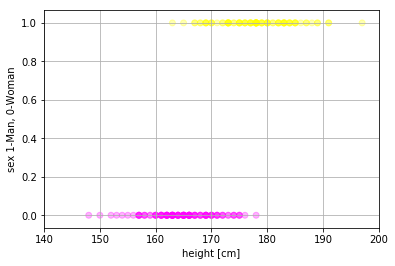

In [6]:
jitter=0.00
scatter(data.height, (data.sex=='M') + (np.random.rand(*data.sex.shape)* 2.0 - 1.0) * jitter, 
        c=data.sex=='M', cmap='spring', alpha=0.3)
xlim(140,200)
xlabel('height [cm]')
ylabel('sex 1-Man, 0-Woman')
grid()

## Logistic regression is for classification

We have learned about linear regression - predicting the value of a continuous variable. This was the task in the house pricing and the height vs weight problems we have seen. However, a linear regression model has an unbounded output. To predict the class of a sample (in our example the sex of a person) we want a bounded output.

To solve this problem we will use a *squashing function* to confine the model's outputs to the $(0,1)$ range. A very popular function is the logistic sigmoid:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

Please note, that we can try to fit a model without the squashing function. We can just treat the binary class identifier as a numerical value, and fit the model to it, that is we want the model to output a number close to 0 for one class and close to 1 for the other class. However, this simplified approach has certain disadvantages. For instance, how do we interpret an output of 2? Is the model extremely confident about its output? Why do we penalize an output of 2 in the same way as the output of 0 (the distance from the target 1 is the same in both cases)?

Text(0.5,1,u'The logistic sigmoid function')

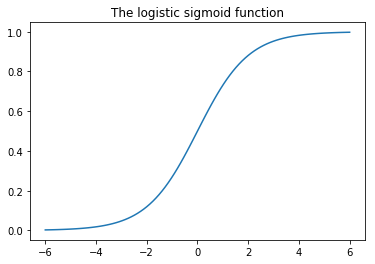

In [7]:
z = linspace(-6,6,100)
plot(z, 1/(1+exp(-z)))
title('The logistic sigmoid function')

## Logistic regression hypothesis

Our hypothesis space contains functions $h(x;\Theta) = \sigma(\Theta^Tx)$. Since for all $x$ we have that $h(x,\Theta)\in[0,1]$, we can treat the value $h(x,\Theta)$ as the conditional probability of the sample $x$ belonging to class 1:

$$
p(y=1|x;\Theta) = h(x,\Theta) = \sigma(\Theta^Tx) = \frac{1}{1+e^{-\Theta^Tx}}
$$

## Logistic regression loss function

We will again use the maximum likelihood principle. Please observe that:

$$
\begin{align}
p(y=y^{(i)}|x^{(i)};\Theta) &= \cases{p(y=1|x;\Theta) &if $y^{(i)}=1$ \\ 1-p(y=1|x;\Theta) &if $y^{(i)}=0$} \\
&= p(y=1|x;\Theta)^{y^{(i)}}(1-p(y=1|x;\Theta))^{(1-y^{(i)})} \\
&= \sigma(\Theta^Tx)^{y^{(i)}}(1-\sigma(\Theta^Tx))^{(1-y^{(i)})}
\end{align}
$$

Therefore the negative log likelihood ($nll$) is:
$$nll(\Theta) = -\sum_{i=1}^{N} y^{(i)} \log \sigma(\Theta^Tx) + (1-y^{(i)})\log(1-\sigma(\Theta^Tx)).$$

This loss function is often referred to as the *cross-entropy* loss.

## Logistic regression training

To fit the logistic regression model we will again need to compute the gradient of the loss function. We will do it in steps. First please observe how simple is the gradient of the logistic sigmoid function:

$$ \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1-\sigma(z))$$

Now let $z^{(i)} = \Theta^Tx^{(i)}$. First lets compute the gradient of the loss on a single sample $nll^{(i)}$:

$$
\frac{\partial nll^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$

The derivative of the first term on the right hand turns out to be very simple:

$$
\begin{align}
\frac{\partial nll^{(i)}}{\partial z^{(i)}} &= \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&= -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} + 
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&= -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=\sigma(z^{(i)})-y^{(i)}
\end{align}
$$

The second term $\frac{\partial z^{(i)}}{\partial\Theta}$ is also easy:

$$
\frac{\partial z^{(i)}}{\partial\Theta} = \frac{\partial \Theta^Tx^{(i)}}{\partial\Theta} = x^{(i)}
$$

Taken together the loss derivative is:

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial nll^{(i)}}{\partial z^{(i)}} = \sum_{i=1}^{N}\left(\sigma(z^{(i)})-y^{(i)}\right)x^{(i)}
$$

The expression can be further simplified by using the data matrix $X$ (whose $i$-th column is the $i$-th sample), the target matrix $Y$, letting $Z=\Theta^T X$, and assuming that the function $\sigma()$ is applied separately to all elements of its input.

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = X\left(\sigma(Z)-Y\right)^T
$$

Unfortunately, the gradient of the loss is no longer linear with $\Theta$. No closed-form solution exists. Therefore we will search for the minimum of the loss function by taking small steps along the gradient of the loss. We will call this the **gradient descent**.

## The Gradient Descent algorithm

The algorithm is very simple:

* $\Theta \gets $ a sane initial value
* `While` not bored:
    * $\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial \Theta}$

We make many $\alpha$-long steps along the gradient, hoping to reach the optimum. 

In [8]:
# Note - we divide the height by 100.
# Otherwise the simple GD algorithm will have trouble converging.
X = np.vstack((np.ones_like(data.height), data.height/100.)).astype(float)
print( X.shape)

Y = np.asarray(data.sex=='M')[None,:]
print(Y.shape)

(2, 200)
(1, 200)


In [9]:
# logistic regression and gradient descent are part of the homework 3
import logreg
reload(logreg)
from logreg import logreg

#note: the step-size needs to be tuned!
ThetaOpt, history = logreg(X, Y, alpha=1e-0, stop_tolerance=1e-8, max_steps=100000)
print(len(history))
print(ThetaOpt)

ImportError: No module named logreg

In [10]:
from matplotlib import animation, pyplot
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(1.40,2.05), ylim=(-0.2, 1.2))
ax.scatter(X[1,:], Y[0,:], c=Y[0,:], cmap='spring')

xx = np.vstack((np.ones((100,)), np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)))
num_frames=100
line, = ax.plot([],[])

xlabel('height [m]')
ylabel('sex 1-Man, 0-Woman')
grid()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = int(1.0*len(history)/num_frames*i)
    Theta = history[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = 1.0/(1.0 + np.exp(-Theta.T.dot(xx)))
    line.set_data(xx[1,:], yy)
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=100, interval=30)

ImportError: No module named JSAnimation

## Batch vs Stochastic gradient descent

The gradient descent algorithm works and finds a reasonable solution. However, sometimes we would like to have an algorithm which updates the model after seeing each example:

1. We may have an infinite stream of data - we cannot wait until we see all of it.
2. We may have a redundant data set - many samples are similar, maybe using fewer would give us similar precision?

The very simple idea we will use is to compute gradient only on one (or a few) samples at each iteration. We will call this new algorithm the **stochastic gradient descent**:

* $\Theta \gets$ a sane initial value
* $t \gets 0$ # the step counter
* `while` not bored
    * `for` $s$ `in` shuffled training samples
        * $\Theta \gets \Theta - \alpha_t \frac{\partial \text{loss on example $s$}(\Theta)}{\partial\Theta}$
        
**Important note**: In normal gradient descent the gradient tends to zero as we approach the optimum point, and it is possible to learn without tuning the learning rate. Now we need to *anneal* it ($\alpha_t$ must tend to $0$ with $t$).

### Rules for tuning the step size

In general there are two conditions on the annealing schedule for $\alpha$:

1. $\sum_{t=1}^\infty \alpha_t^2 < \infty$
2. $\sum_{t=1}^\infty \alpha_t = \infty$

Or intuitively, we need to converge to a solution (1.), but we also need to be able to get arbitrarily far from the starting point (2.). 

In practice, we use a step size rule similar to:
$$
\alpha_t = \alpha_0 \frac{\tau}{\max(\tau, t)}
$$
unfortunately, we need to tune the step size.

### Interpretation of stochastic gradient descent

We assume that there is a data generating distribution, $P(X,Y)$. We want to minimize the expected value of a loss $J$ function over it. Thus our ultimate goal is to solve:

$$
\min_\Theta \mathbb{E}[J(x,y,\Theta)]_{x,y \sim P(X,Y)}
$$

However, we cannot compute the expected value, since we do not know the distribution $P(x,y)$. All we can do is approximate the expectation with the mean over the training set:

$$
\min_\Theta \mathbb{E}[J(x,y,\Theta)]_{x,y \sim P(X,Y)} \approx \min_\Theta \frac{1}{N}\sum_{i=1}^N J(x^{(i)},y^{(i)},\Theta)
$$

In **batch gradient descent** we use the full training dataset to compute the expected loss and its gradient.

In **stochastic gradient descent** sample one example from the training set, take step in the direction of the gradient on that example, then sample another example, then another... This works, because the expected value is a liner operator and the gradient of the expected loss is the expected gradient of the loss:

$$
\frac{\partial \mathbb{E}[J(x,y,\Theta)]_{x,y \sim P(X,Y)}}{\partial\Theta} = \mathbb{E}\left[\frac{\partial J(x,y,\Theta)}{\partial\Theta}\right]_{x,y \sim P(X,Y)}
$$

On very large and redundant datasets stochastic gradient descent may be a lot faster. First, if model parameters are very far from their optimum, even a few examples may point us in the large direction. Second, the loss function we minimize may be very curvy and even with the perfect gradient we cannot take a large step. It is beneficial to take many small steps quickly. Lastly, stochastic gradient descent may be more resilient to local optimums. 

In [17]:
# logistic regression and gradient descent are part of the homework 3
import logreg
reload(logreg)
from logreg import sgd_logreg

#note: the step-size annealing schedule needs to be tuned!
ThetaOptSGD, history_sgd = sgd_logreg(X,Y, alpha_fun=lambda t: 1e-1/np.maximum(1, t/1e5), max_steps=2e6)
print(len(history_sgd))
print(ThetaOpt)

Step 50000 (250.000000 full data passes), nll=0.170314, Theta = [-32.565955005213389, 18.818516827239623]
Step 100000 (500.000000 full data passes), nll=1.260721, Theta = [-43.748975167058688, 25.529365250437245]
Step 150000 (750.000000 full data passes), nll=0.263654, Theta = [-48.989984602694207, 28.790113674612925]
Step 200000 (1000.000000 full data passes), nll=0.065961, Theta = [-51.766488467596439, 30.251123792658365]
Step 250000 (1250.000000 full data passes), nll=0.035080, Theta = [-53.539745552503511, 31.077742358976217]
Step 300000 (1500.000000 full data passes), nll=0.192364, Theta = [-54.678568255024338, 31.81313033955546]
Step 350000 (1750.000000 full data passes), nll=0.111340, Theta = [-55.539475455316548, 32.363934711372139]
Step 400000 (2000.000000 full data passes), nll=0.077843, Theta = [-56.228275255938328, 32.752673456004878]
Step 450000 (2250.000000 full data passes), nll=0.419284, Theta = [-56.807550947490078, 33.032529106530554]
Step 500000 (2500.000000 full dat


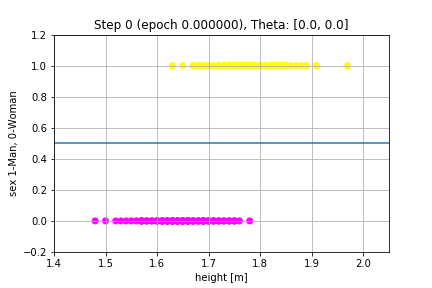
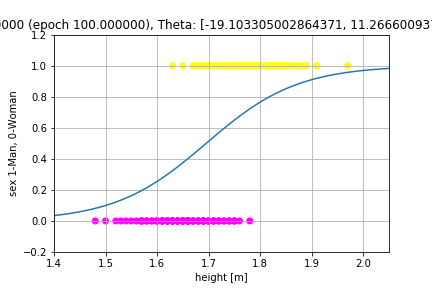
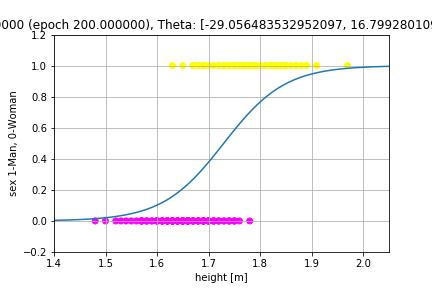
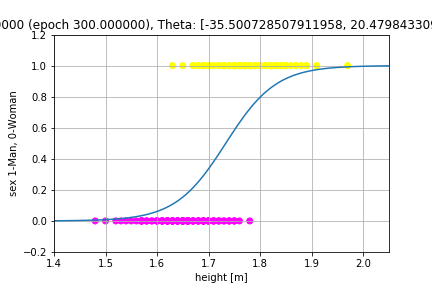
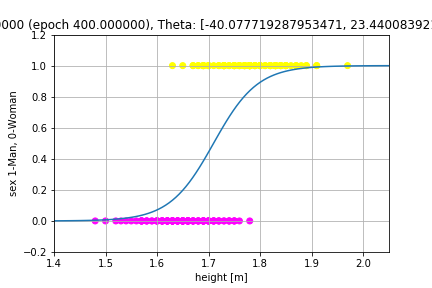
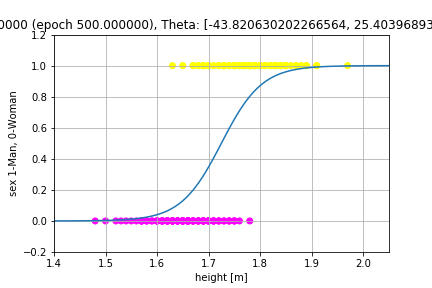
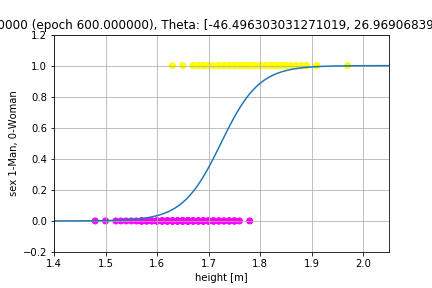
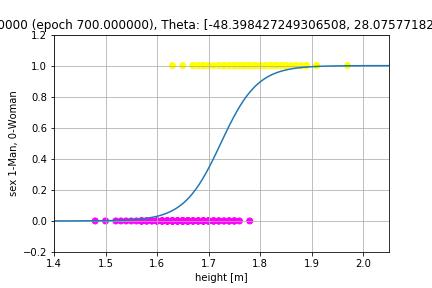
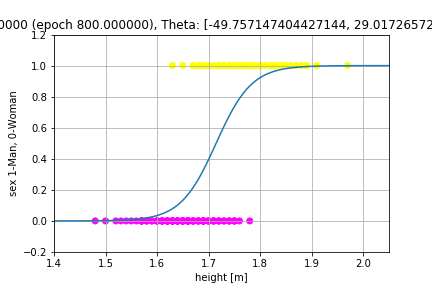
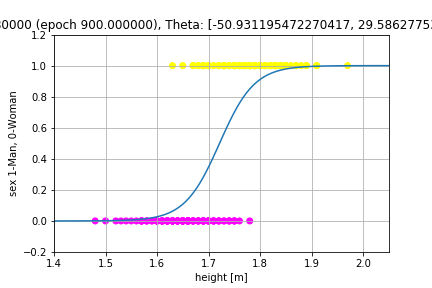
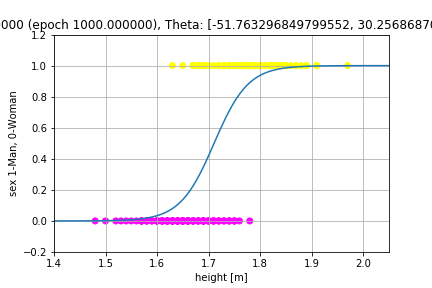
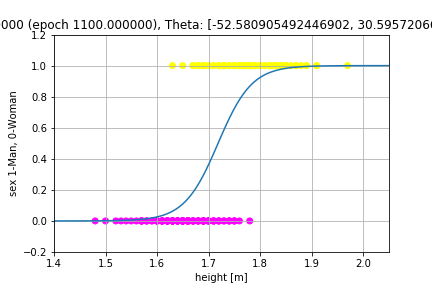
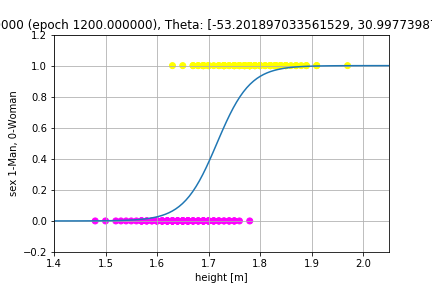
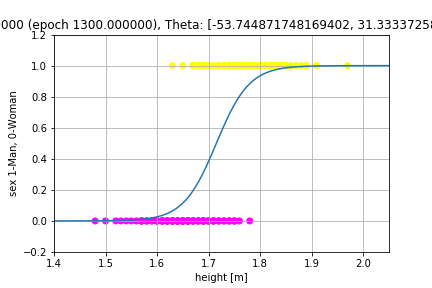
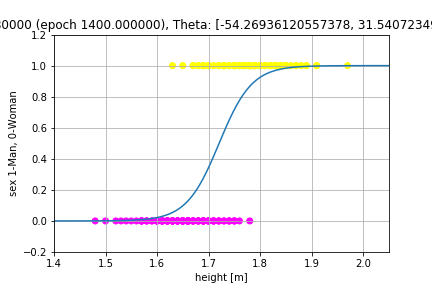
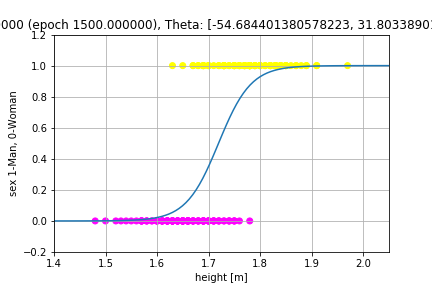
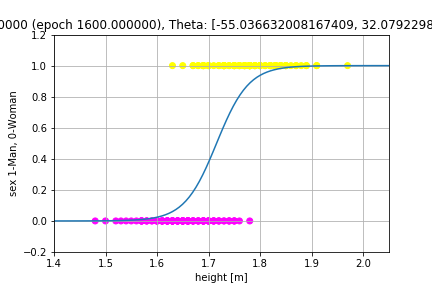
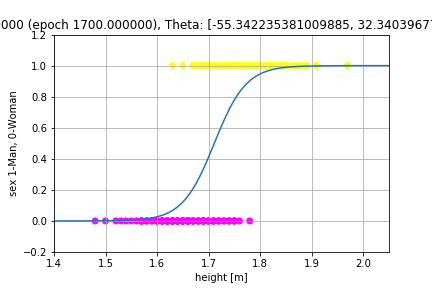
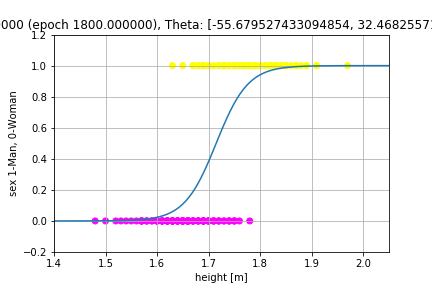
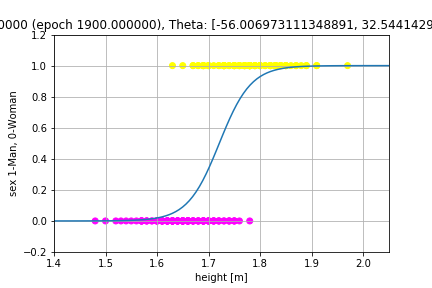
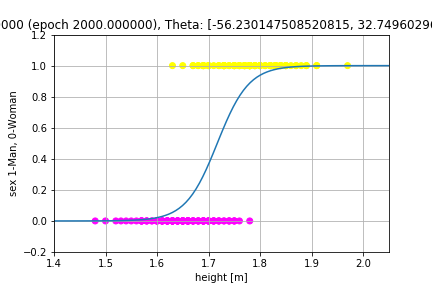
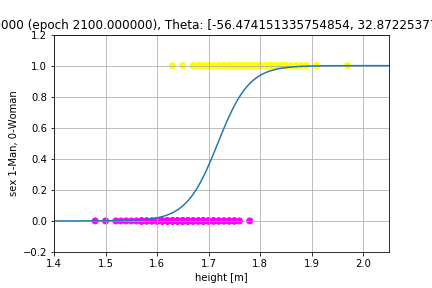
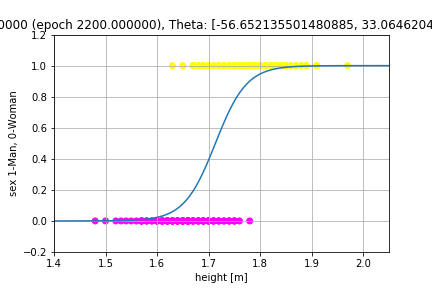
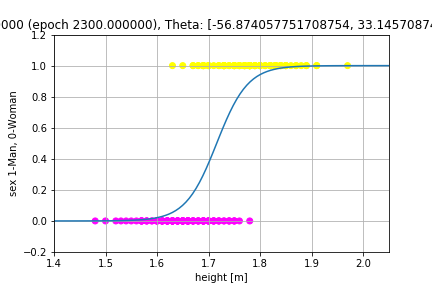
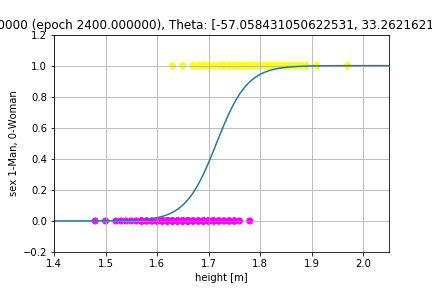
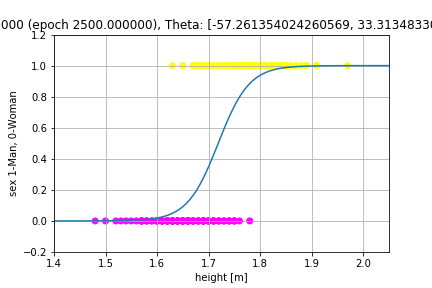
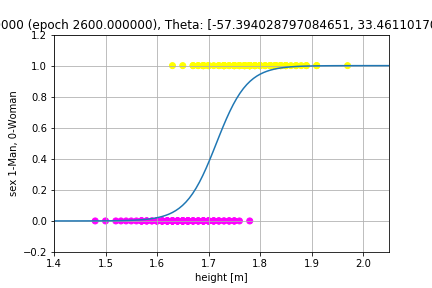
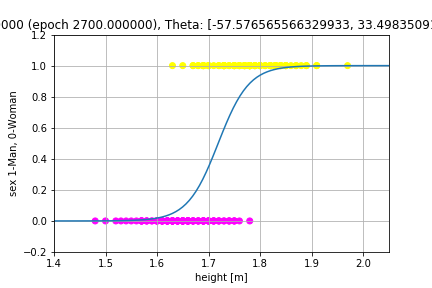
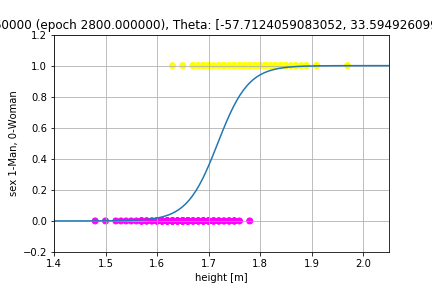
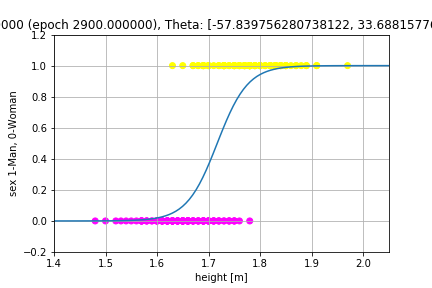
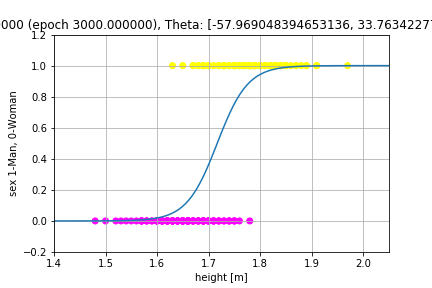
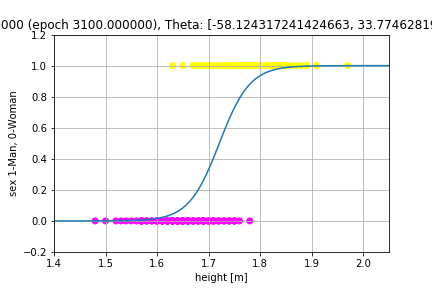
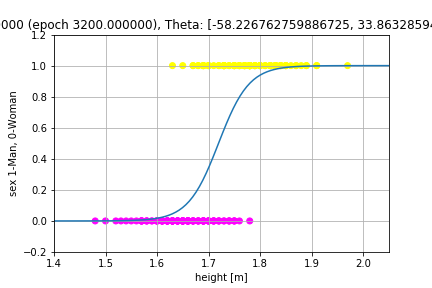
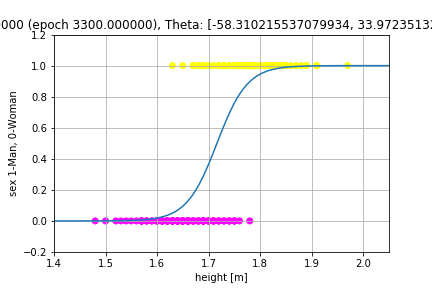
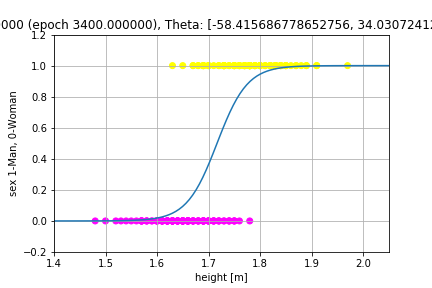
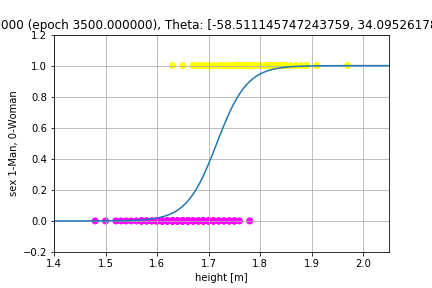
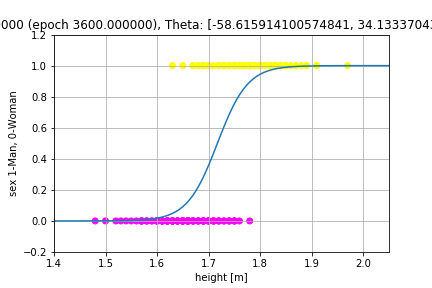
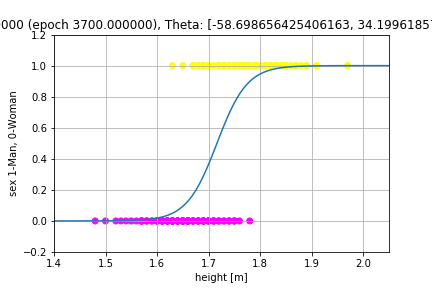
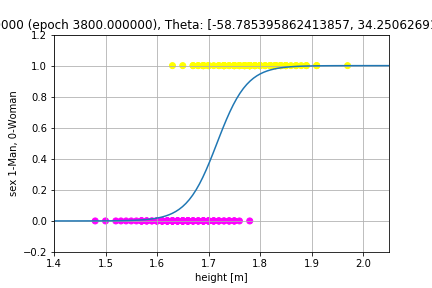
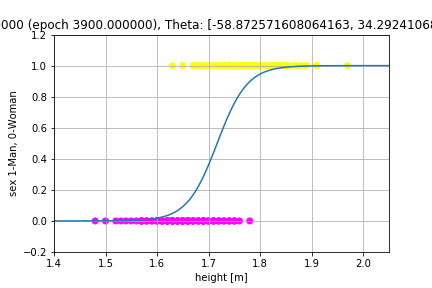
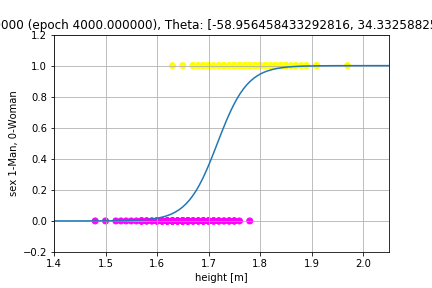
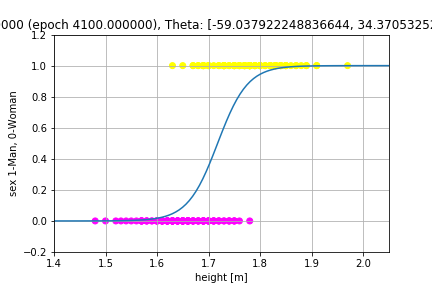
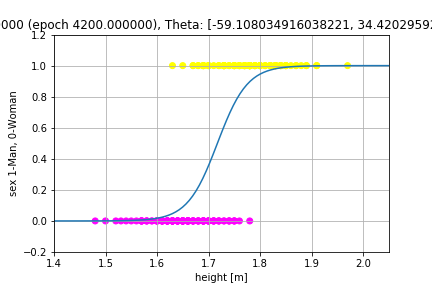
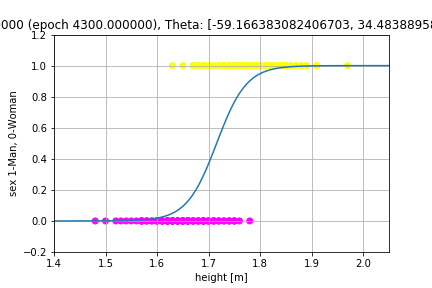
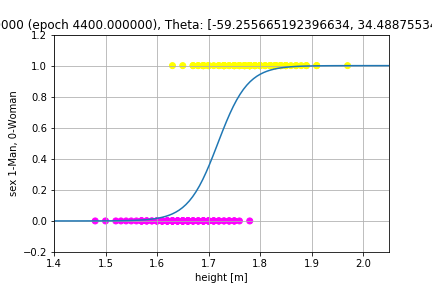
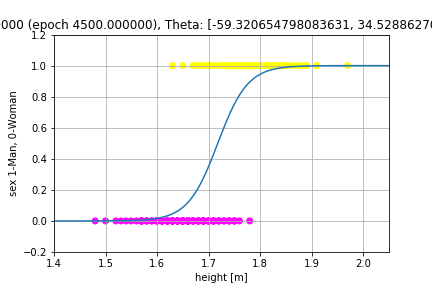
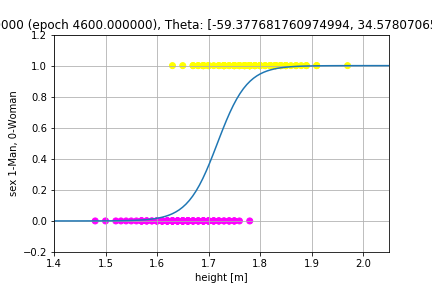
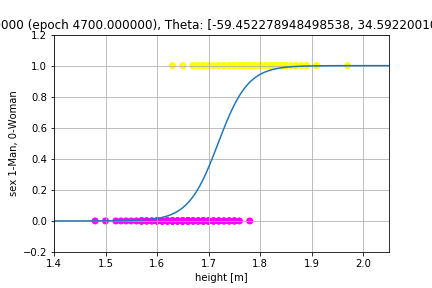
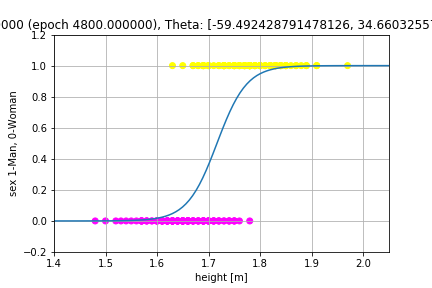
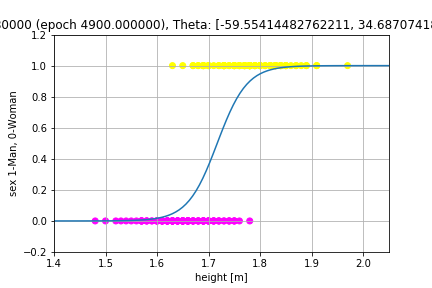
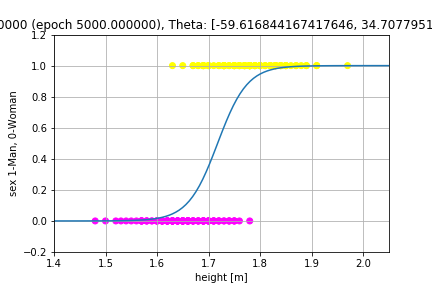
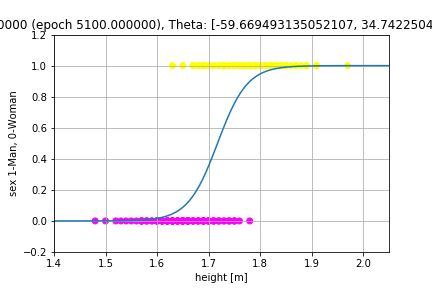
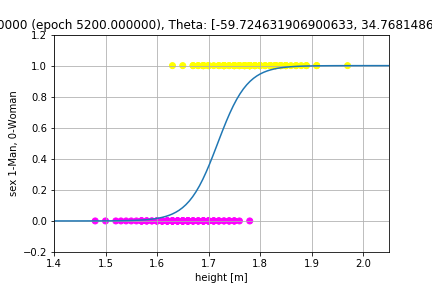
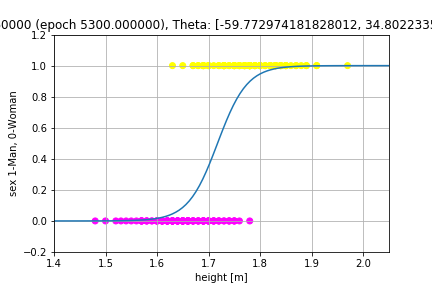
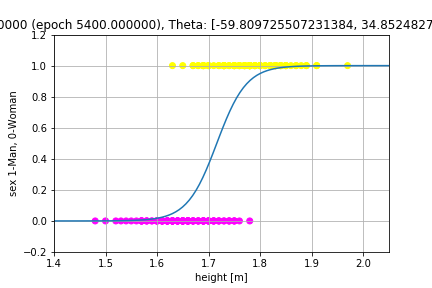
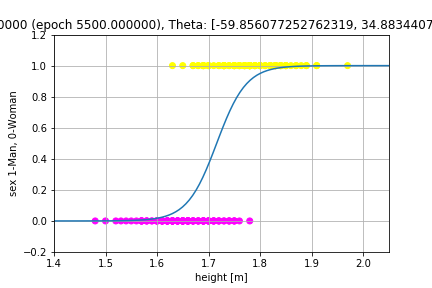
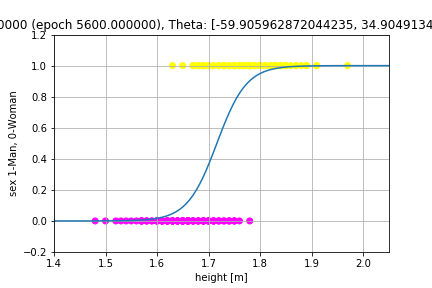
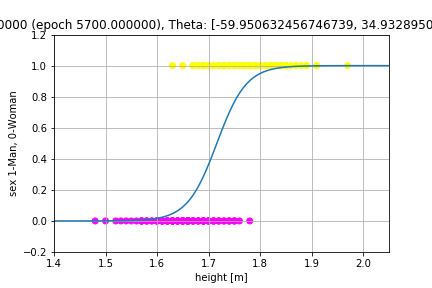
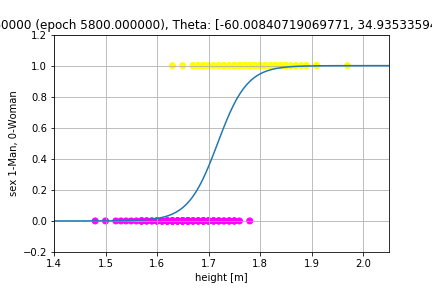
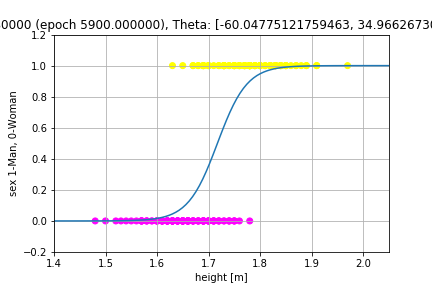
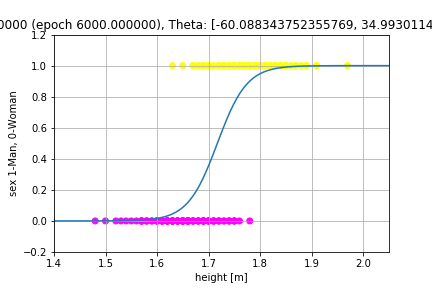
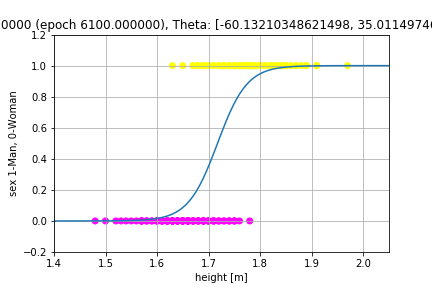
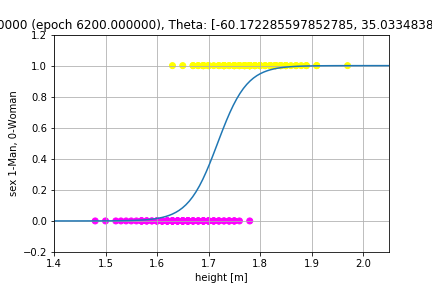
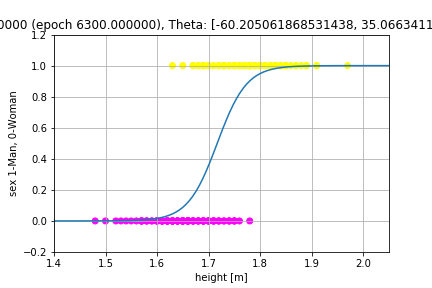
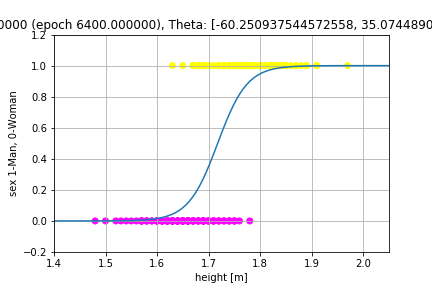
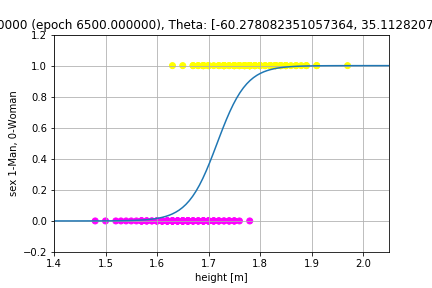
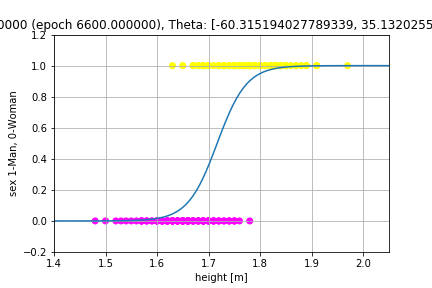
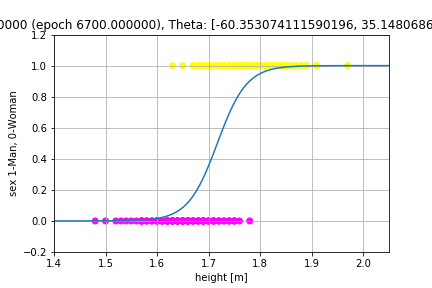
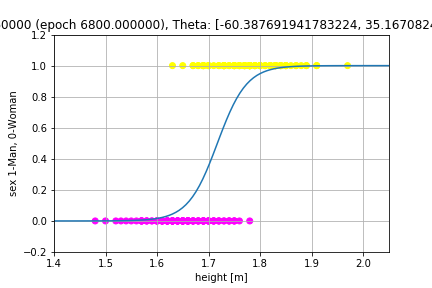
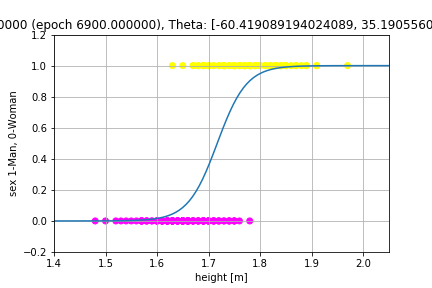
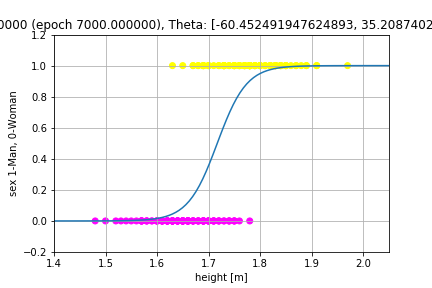
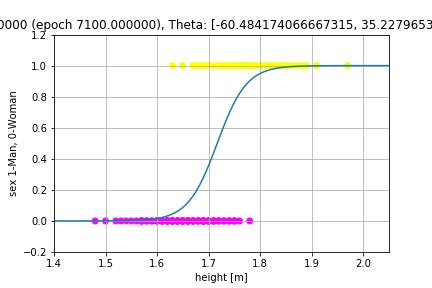
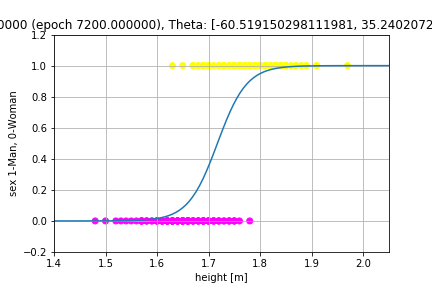
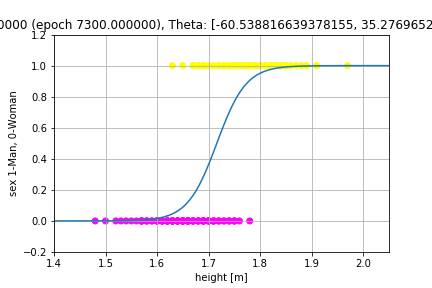
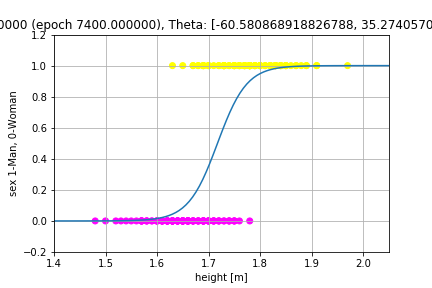
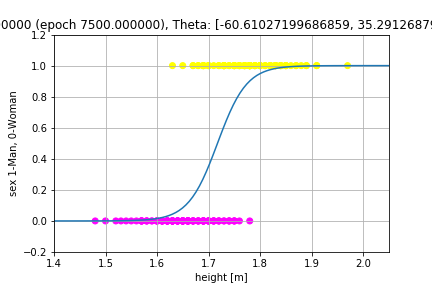
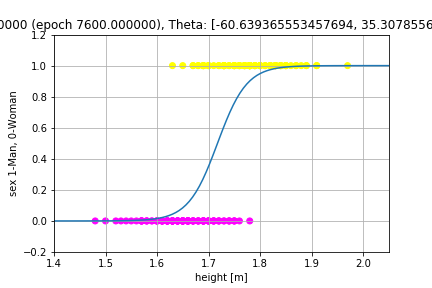
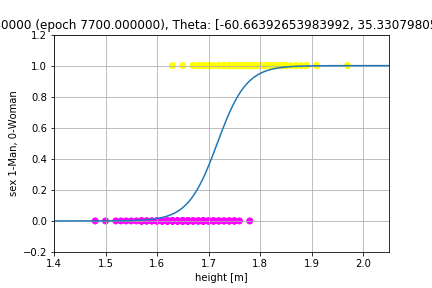
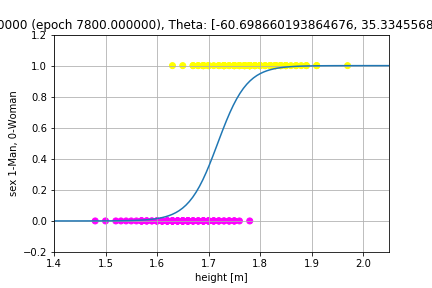
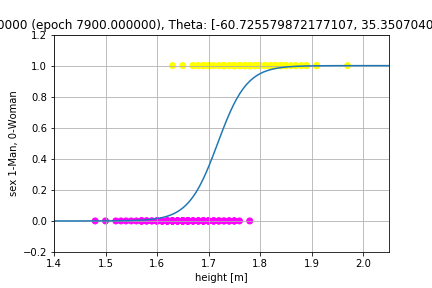
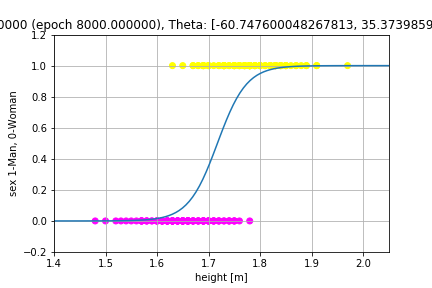
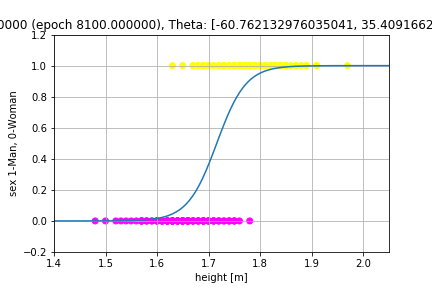
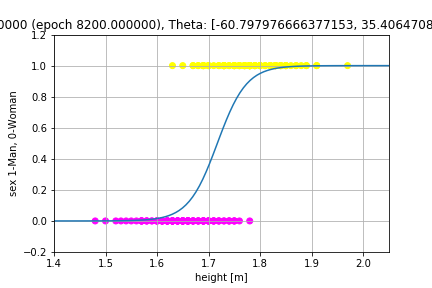
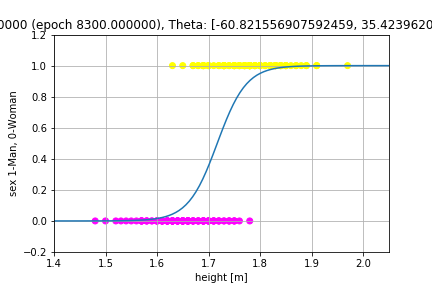
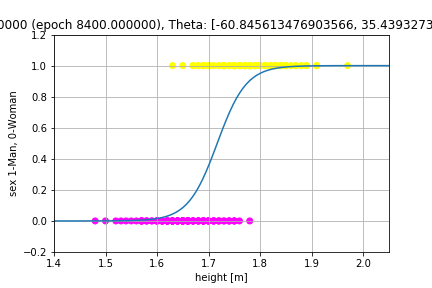
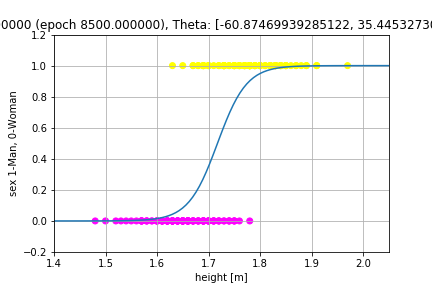
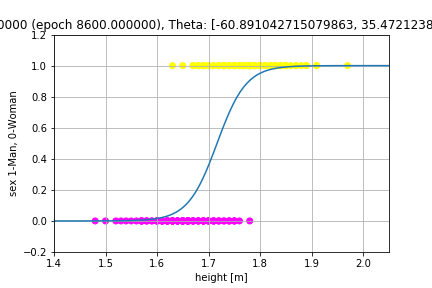
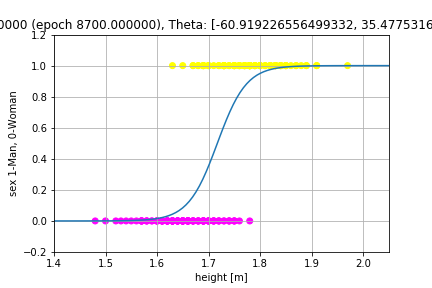
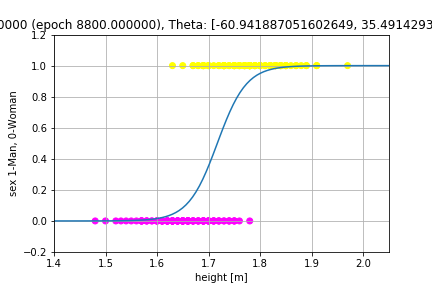
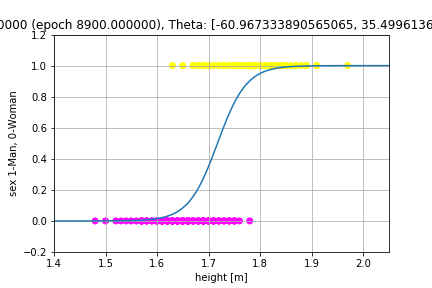
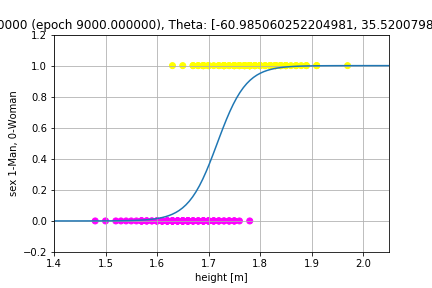
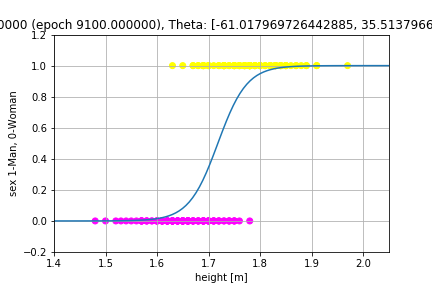
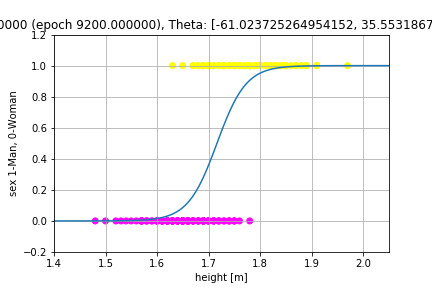
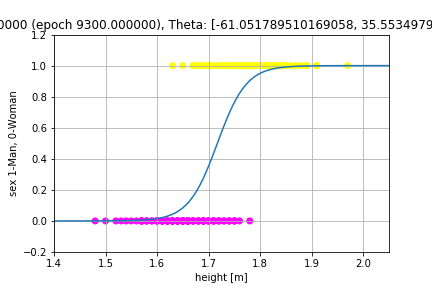
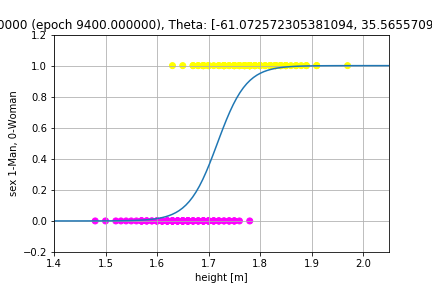
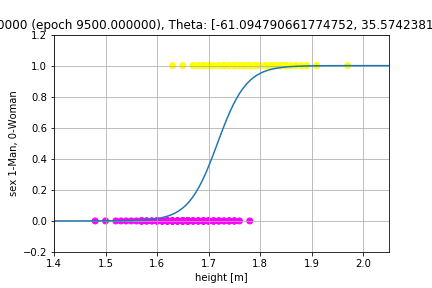
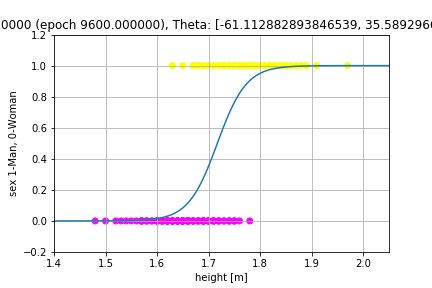
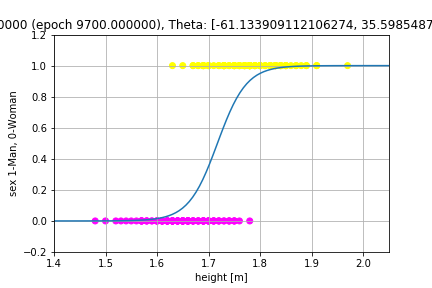
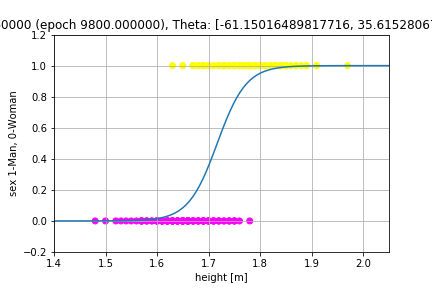
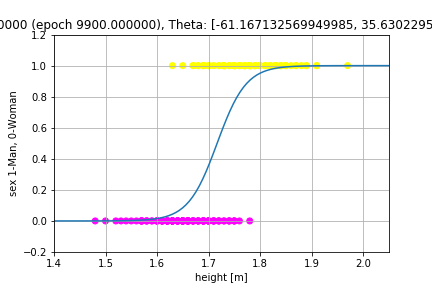

In [18]:
fig = plt.figure()
ax = plt.axes(xlim=(1.40,2.05), ylim=(-0.2, 1.2))
ax.scatter(X[1,:], Y[0,:], c=Y[0,:], cmap='spring')

xx = np.vstack((np.ones((100,)), np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)))
num_frames=100
line, = ax.plot([],[])

xlabel('height [m]')
ylabel('sex 1-Man, 0-Woman')
grid()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    step = int(1.0*len(history_sgd)/num_frames*i)
    Theta = history_sgd[step]
    ax.set_title('Step %d (epoch %f), Theta: %s' % (step, 1.0* step/X.shape[1], list(Theta.flat),))
    yy = 1.0/(1.0 + np.exp(-Theta.T.dot(xx)))
    line.set_data(xx[1,:], yy)
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=100, interval=30)

## Historical flashback - the Perceptron algorithm

One very famous early attempt at learning was the Perceptron (F. Rosenblatt, 1957).

![The preceptron machine](03-perceptron.png)

At its core, the perceptron learns a classifier function:

$$
h(x,\Theta) = \begin{cases}
    1 & \text{if } \Theta^Tx \geq 0 \\
    0 & \text{otherwise}
\end{cases}
$$

It is trained using the following on-line algorithm:

* $\Theta \gets$ a sane initial value
* `while` not converged
    * `for` $s$ `in` shuffled training samples
        * $\Theta \gets \Theta + \alpha (y^{(i)}-h(x^{(i)}, \Theta))x^{(i)}$
        
Please note, that this is similar in operation to the stochastic gradient descent over the logistic regression loss. However, the perceptron's output is not differentiable: it is a hard threshold function. Also, the preceptron only learns on its *mistakes*, i.e. the parameters $\Theta$ are changed only when $y^{(i)} \neq h(x^{(i)}, \Theta)$.

When the training data are linearly separable (i.e. there exist a hyperplane that separates the two classes), the perceptron algorithm finds such a hyperplane and converges (it makes no mistakes, thus no further updates to $\Theta$ are made).

## Softmax regression - dealing with multiple classes

When we have $k$ classes we need a model that can predict the probability distribution over all classes. An easy solution is to assume that our model has $k$ outputs, each in the range $[0,1]$ and summing to $1$.

Typically, we will learn a set of parameters for each class. Therefore, $\Theta$ will be a matrix of size $n \times k$ where $n$ is the number of data features (including the bias terms), and $k$ is the number of classes. Therefore $z = \Theta^T x$ will be a vector of $k$ per-class scores. We will normalize them using the SoftMax function:

$$
\text{SoftMax}(z)_j = \frac{e^{z_j}}{\sum_k e^{z_k}}
$$

The model learns the function

$$
h(x, \Theta) = \text{SoftMax}(\Theta^Tx).
$$

The SoftMax regression loss is the $k$-class cross-entropy:

$$
J(\Theta) = -\sum_{i=1}^N\sum_k[y^{(i)}=k]\log \left(h(x^{(i)}, \Theta)_k\right)
$$

### Examples of softmax regression

We can look at the results of softmax regression by picturing the parameters learned for each class.

We will use two datasets containing images - MNIST and CIFAR10. They both contain samples belonging to 10 classes. Therefore for each dataset we will find a set of parameters for each of the 10 classes. Then we will display the parameters as images. We can think about them as prototype vectors sensitive to elements of a given class.

In [15]:
data_path = os.environ.get('PYTORCH_DATA_PATH',
                           '../data')

# Please note, these lectures still use the convention that each sample is a column vector. 
# The code for later lectures will switch to the more implementation-friendly convention
# in which everythoing is transposed....
mnist_train_dataset = torchvision.datasets.MNIST(
    data_path, train=True, download=True)
mnist_train_data = mnist_train_dataset.train_data.numpy().astype(np.float32).reshape(-1, 28*28).T / 255.0
mnist_train_labels = mnist_train_dataset.train_labels.numpy().ravel()

mnist_test_dataset = torchvision.datasets.MNIST(
    data_path, train=False, download=True)
mnist_test_data = mnist_test_dataset.test_data.numpy().astype(np.float32).reshape(-1, 28*28).T / 255.0
mnist_test_labels = mnist_test_dataset.test_labels.numpy().ravel()

In [16]:
import logreg
reload(logreg)
from logreg import softmax
from common.plotting import plot_mat

# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will make more sense around 6th lecture
ThetaMnist = softmax(mnist_train_data, mnist_train_labels, 10, maxiter=25)

In [17]:
predicted_train_labels = ThetaMnist.T.dot(mnist_train_data).argmax(0)
print ("Train error rate: %f" % ((predicted_train_labels != mnist_train_labels).mean(), ))

predicted_test_labels = ThetaMnist.T.dot(mnist_test_data).argmax(0)
print ("Test error rate: %f" % ((predicted_test_labels != mnist_test_labels).mean(), ))

Train error rate: 0.082750
Test error rate: 0.080900


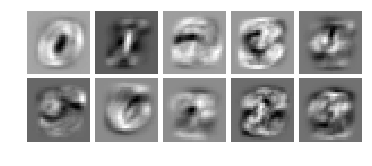

In [18]:
plot_mat(ThetaMnist[:,:].reshape(28,28,1,-1).transpose(3,2,0,1), cmap='gray')

In [19]:
data_path = os.environ.get('PYTORCH_DATA_PATH',
                           '../data')

# Please note, these lectures still use the convention that each sample is a column vector. 
# The code for later lectures will switch to the more implementation-friendly convention
# in which everythoing is transposed....
cifar_train_dataset = torchvision.datasets.CIFAR10(
    data_path, train=True, download=True)
cifar_train_data = cifar_train_dataset.train_data.astype(np.float32).reshape(-1, 32*32*3).T / 255.0
cifar_train_labels = np.array(cifar_train_dataset.train_labels)

cifar_test_dataset = torchvision.datasets.CIFAR10(
    data_path, train=False, download=True)
cifar_test_data = cifar_test_dataset.test_data.astype(np.float32).reshape(-1, 32*32*3).T / 255.0
cifar_test_labels = np.array(cifar_test_dataset.test_labels)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will make more sense around 6th lecture
ThetaCifar = softmax(cifar_train_data, cifar_train_labels, 10, maxiter=50)

In [21]:
predicted_train_labels = ThetaCifar.T.dot(cifar_train_data).argmax(0)
print ("Train error rate: %f" % ((predicted_train_labels != cifar_train_labels).mean(), ))

predicted_test_labels = ThetaCifar.T.dot(cifar_test_data).argmax(0)
print ("Test error rate: %f" % ((predicted_test_labels != cifar_test_labels).mean(), ))

Train error rate: 0.597520
Test error rate: 0.604300


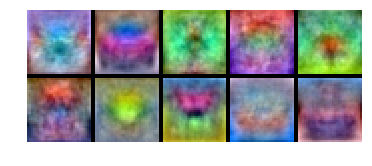

In [22]:
# We skip the first row of parameters because they represent the 
# constant term. The remaming ones are rehsaped as grayscale images
#
# The 10 classes are:
# ------------------------------------------------
# | airplane | automobile | bird  | cat  | deer  |
# |----------|------------|-------|------|-------|
# |   dog    |     frog   | horse | ship | truck |
# ------------------------------------------------
#
# Again, the learned parameters ressebmle the average image in each class.
#
plot_mat(ThetaCifar[:,:].reshape(32,32,3,-1).transpose(3,2,0,1))

## Further reading
1. Andrew Ng "CS229 Lecture notes", http://cs229.stanford.edu/notes/cs229-notes1.pdf
2. Leon Bottou "Stochastic Gradient Descent Tricks", http://leon.bottou.org/papers/bottou-tricks-2012